In [323]:
import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary

### What is classification?

Classification is a problem where you try to predict whether something is one thing or another. There are several types of classifications:
1. Binary Classification: Predict something to be one of two things (e.g. email is spam or not)
2. Multi-class Classification: Predict something to be one of more than two things (e.g. what type of dog breed)
3. Multi-label Classification: Predict something to be two or more of several things (e.g. what tags this post should be)

### Neural Network Architecture

There are several hyperparameters that define a model which are different depending on the type of problem

| Hyperparameter | Binary Classification | Multiclass Binary Classification |
| --- | --- | --- |
| Input layer shape `in_features` | Same as number of features used | Same as binary |
| Hidden layers | Dependent on problem. Can be from 1 to as many as you like | Same as binary |
| Neurons per hidden layer | Dependent on problem. Usually 1-512. Need to experiment | Same as binary |
| Output layer shape `out_features` | 1 (one label or the other) | 1 per label |
| Hidden layer activation | ReLU generally but others used | Also ReLU |
| Output activation | Sigmoid `torch.sigmoid` | Softmax `torch.softmax` |
| Loss function | Binary crossentropy `torch.nn.BCELoss` | Cross entropy `torch.nn.CrossEntropy` |
| Optimizer | SGD or Adam | SGD or Adam also

### 1. Create Data

Let's make data by plotting points in a circle pattern

In [324]:
# create points like a circle
X, y = make_circles(1000, # 1000 samples
                    noise = 0.02,
                    random_state=69)

In [325]:
# see first few samples
X[:5]

array([[-0.50770953, -0.65521138],
       [ 0.78930078, -0.00400812],
       [ 0.13736431, -0.7677156 ],
       [-0.71591705, -0.3193879 ],
       [ 0.69422763, -0.33934349]])

Since X has two numbers per sample, it means it has two features. This is important because when we put X in the model it will also need to have two input shape

To make the data easier to visualize, use pandas DataFrame

In [326]:
df = pd.DataFrame({"x1": X[:, 0], "x2": X[:, 1],"y": y})

df.head()

,x1,x2,y
0,-0.507710,-0.655211,1
1,0.789301,-0.004008,1
2,0.137364,-0.767716,1
3,-0.715917,-0.319388,1
4,0.694228,-0.339343,1


How many amount of each y are there?

In [327]:
df.y.value_counts()

y
1    500
0    500
Name: count, dtype: int64

Both balanced which is good

Visualize the data to see that it is indeed circular

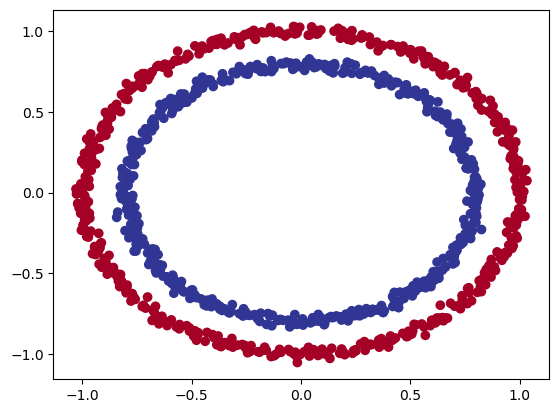

In [328]:
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

Now what the model wants to predict is create a line that can seperate the blue and red as accurately as possible

Since the data is in lists, we need to put the list into a PyTorch tensor because PyTorch models prefer it that way.

In [329]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

Then split into 80% training data and 20% test data

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, # 20% of data
                                                    random_state=69)

len(X_train), len(X_test)

(800, 200)

### 2. Create Model

Make sure to put the objects and the model at a specific device

In [331]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Create the model wary about the shape of the input which is 2

In [332]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()

        # create two layers
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(2, 4), # 2 features and 4 outputs
            nn.ReLU(), # for binary classification
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    
# create model object
model = CircleModel().to(device)

This model has four hidden units which is arbitrarily set.

Let's try to check what type of output it creates

In [333]:
model(X_test[:20].to(device))

tensor([[ 0.5360],
        [ 0.5404],
        [ 0.1100],
        [ 0.2065],
        [ 0.4909],
        [ 0.4401],
        [ 0.2652],
        [-0.2781],
        [ 0.4425],
        [-0.2998],
        [ 0.3373],
        [-0.1599],
        [ 0.2708],
        [-0.0298],
        [ 0.4278],
        [-0.1276],
        [ 0.1009],
        [ 0.4620],
        [-0.1272],
        [ 0.3433]], device='cuda:0', grad_fn=<AddmmBackward0>)

The values we want to predict are either 0 and 1 but the model outputs something different. This will be able to be converted later.

But first we choose the loss function and the optimizer for this model. These are also different depending on what type of problem the model aims to solve

| Optimizer| Problem type | PyTorch |
| --- | --- | --- |
| Stochastic Gradient Descent (SGD) | Any | `torch.optim.SGD()` |
| Adam | Any | `torch.optim.Adam()` |


| Loss function | Problem type | PyTorch |
| --- | --- | --- |
| Binary cross entropy | Binary classification | `torch.nn.BCELossWithLogits` or `torch.nn.BCELoss` |
| Cross entropy loss | Multiclass classification | `torch.nn.CrossEntropyLoss` |
| Mean squared error (MSE) or L2 Loss | Regression | `torch.nn.MSELoss` | 

Therefore we choose an optimizer of Adam and loss function of binary cross entropy.

However there are two types of binary cross entropy. `torch.nn.BCELossWithLogits` is basically `torch.nn.BCELoss` but with a sigmoid function. Since the model already has a sigmoid function, we use the one without logits instead. A logit is made from a logit function which is the inverse of the sigmoid function

In [334]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

Another thing to consider is some evaluation metrics. For classification, it is decent to use accuracy to see how much of its predictions are correct

In [335]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### 3. Train Model

As mentioned earlier, the output of the model is some decimal place. This represents the value of probability after sigmoid. The last layer of the model before the activation function is a linear layer which outputs logits. These logits are then transcribed with sigmoid to present its prediction probability. This probability will be split with some probability threshold where values >=0.5 = 1 and <=0.5 = 1.

In [336]:
# probability prediction
y_logits = model(X_test[:10].to(device))

# round to labels of 0 or 1
y_labels = torch.round(torch.sigmoid(y_logits))

y_labels.squeeze()

tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 0.], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

Knowing how to process the model's output, we can start the training loop of the model

In [337]:
# set seed
torch.manual_seed(69)

# no of epochs
epochs = 1000

# put all data to device
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

# training loop
for epoch in range(epochs):

    # TRAINING
    model.train()

    # forward pass
    y_logits = model(X_train).squeeze() # the additional dimension is not necessary
    y_pred = torch.round(torch.sigmoid(y_logits))

    # calculate metrics
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # optimize zero grad
    optimizer.zero_grad()

    # loss backwards
    loss.backward()

    # optimizer step
    optimizer.step()


    # TESTING
    model.eval()

    with torch.inference_mode():
        # forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # calculate metrics
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)

    # show wahts going on
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:.5f} | Training Accuracy: {acc:.2f}% | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%")

Epoch: 0 | Training Loss: 0.70349 | Training Accuracy: 51.00% | Testing Loss: 0.71293 | Testing Accuracy: 49.00%
Epoch: 100 | Training Loss: 0.61918 | Training Accuracy: 70.75% | Testing Loss: 0.63252 | Testing Accuracy: 71.00%
Epoch: 200 | Training Loss: 0.45528 | Training Accuracy: 84.62% | Testing Loss: 0.45805 | Testing Accuracy: 84.50%
Epoch: 300 | Training Loss: 0.27242 | Training Accuracy: 93.88% | Testing Loss: 0.27702 | Testing Accuracy: 93.00%
Epoch: 400 | Training Loss: 0.16326 | Training Accuracy: 96.88% | Testing Loss: 0.15590 | Testing Accuracy: 97.50%
Epoch: 500 | Training Loss: 0.10215 | Training Accuracy: 99.12% | Testing Loss: 0.10186 | Testing Accuracy: 98.50%
Epoch: 600 | Training Loss: 0.07297 | Training Accuracy: 99.25% | Testing Loss: 0.07200 | Testing Accuracy: 98.50%
Epoch: 700 | Training Loss: 0.05714 | Training Accuracy: 99.62% | Testing Loss: 0.05665 | Testing Accuracy: 98.50%
Epoch: 800 | Training Loss: 0.04703 | Training Accuracy: 99.62% | Testing Loss: 0.

Let's visualize how well the model did with the predictions

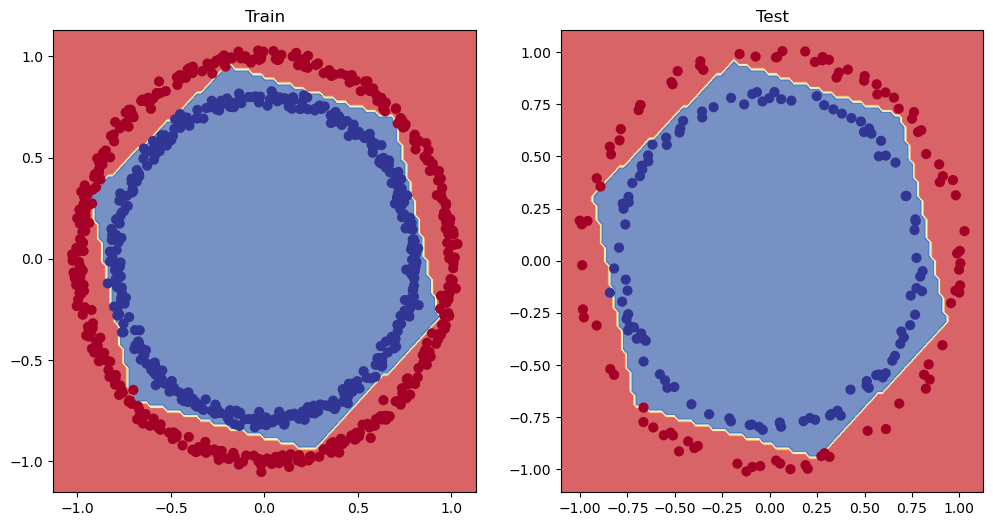

In [338]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)